In [10]:
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.models import load_model  
from sklearn import metrics
import os

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

In [11]:
db_connection = mysql.connector.connect(
  host="",
  user="",
  passwd="",
  database="mps_data"
)
cursor = db_connection.cursor()

query = '''
SELECT
    DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00') as date, 
    COUNT(*) as count,
    MAX(t.boxing_day) as boxing_day,
    MAX(t.boxing_day_obs) as boxing_day_obs,
    MAX(t.christmas_day) as christmas_day,
    MAX(t.christmas_day_obs) as christmas_day_obs,
    MAX(t.good_friday) as good_friday,
    MAX(t.may_day) as may_day,
    MAX(t.new_years_day) as new_years_day,
    MAX(t.new_years_day_obs) as new_years_day_obs,
    MAX(t.platinum_jubilee) as platinum_jubilee,
    MAX(t.spring_bank_holiday) as spring_bank_holiday,
    MAX(t.state_funeral) as state_funeral,
    MAX(t.outlier) as outlier
FROM use_of_force u
INNER JOIN rq3_add_variables t ON DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00') = t.date
WHERE u.date_time > '2019-01-01 00:00:00' AND u.PrimaryConduct > 0
GROUP BY DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00');
'''
time_series_daily = pd.read_sql(query, db_connection)

scaler = MinMaxScaler()
time_series_daily['count'] = scaler.fit_transform(time_series_daily[['count']])

time_series_daily['date'] = pd.to_datetime(time_series_daily['date'])
time_series_daily = time_series_daily.set_index('date')  
df = time_series_daily[['count', 'boxing_day', 'boxing_day_obs', 'christmas_day',
       'christmas_day_obs', 'good_friday', 'may_day', 'new_years_day',
       'new_years_day_obs', 'platinum_jubilee', 'spring_bank_holiday',
       'state_funeral', 'outlier']].values

C:\Users\Nikita\AppData\Local\Temp/ipykernel_17400/1830079314.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_daily = pd.read_sql(query, db_connection)


In [12]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs[i:(i+seq_size)]
        after_window = obs[i+seq_size, 0]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

sequence_size = 365
x, y = to_sequences(sequence_size, df)

train_test_split_index = len(x) - 60

x_train = x[:train_test_split_index]
y_train = y[:train_test_split_index]

x_test = x[train_test_split_index:]
y_test = y[train_test_split_index:]

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (761, 365, 13)
Shape of test set: (60, 365, 13)


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=1024,
    num_heads=4,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[256, 128, 64],
    mlp_dropout=0.2,
    dropout=0.2,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
# print(model.summary())

os.makedirs("checkpoints_Transformer_daily", exist_ok=True)
model_checkpoint = ModelCheckpoint('checkpoints_Transformer_daily/model_epoch_{epoch:02d}.h5', 
                                   monitor='val_loss', verbose=1, save_best_only=False, mode='min')

early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    shuffle=False,
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint],
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/100
86/86 [==============================] - ETA: 0s - loss: 0.0255
Epoch 1: saving model to checkpoints_Transformer_agg_multi\model_epoch_01.h5
86/86 [==============================] - 6s 50ms/step - loss: 0.0255 - val_loss: 0.0103
Epoch 2/100
85/86 [============================>.] - ETA: 0s - loss: 0.0171
Epoch 2: saving model to checkpoints_Transformer_agg_multi\model_epoch_02.h5
86/86 [==============================] - 4s 47ms/step - loss: 0.0170 - val_loss: 0.0137
Epoch 3/100
85/86 [============================>.] - ETA: 0s - loss: 0.0137
Epoch 3: saving model to checkpoints_Transformer_agg_multi\model_epoch_03.h5
86/86 [==============================] - 4s 47ms/step - loss: 0.0137 - val_loss: 0.0105
Epoch 4/100
85/86 [============================>.] - ETA: 0s - loss: 0.0133
Epoch 4: saving model to checkpoints_Transformer_agg_multi\model_epoch_04.h5
86/86 [==============================] - 4s 47ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 5/100
85/86 [=================

0.006057795602828264

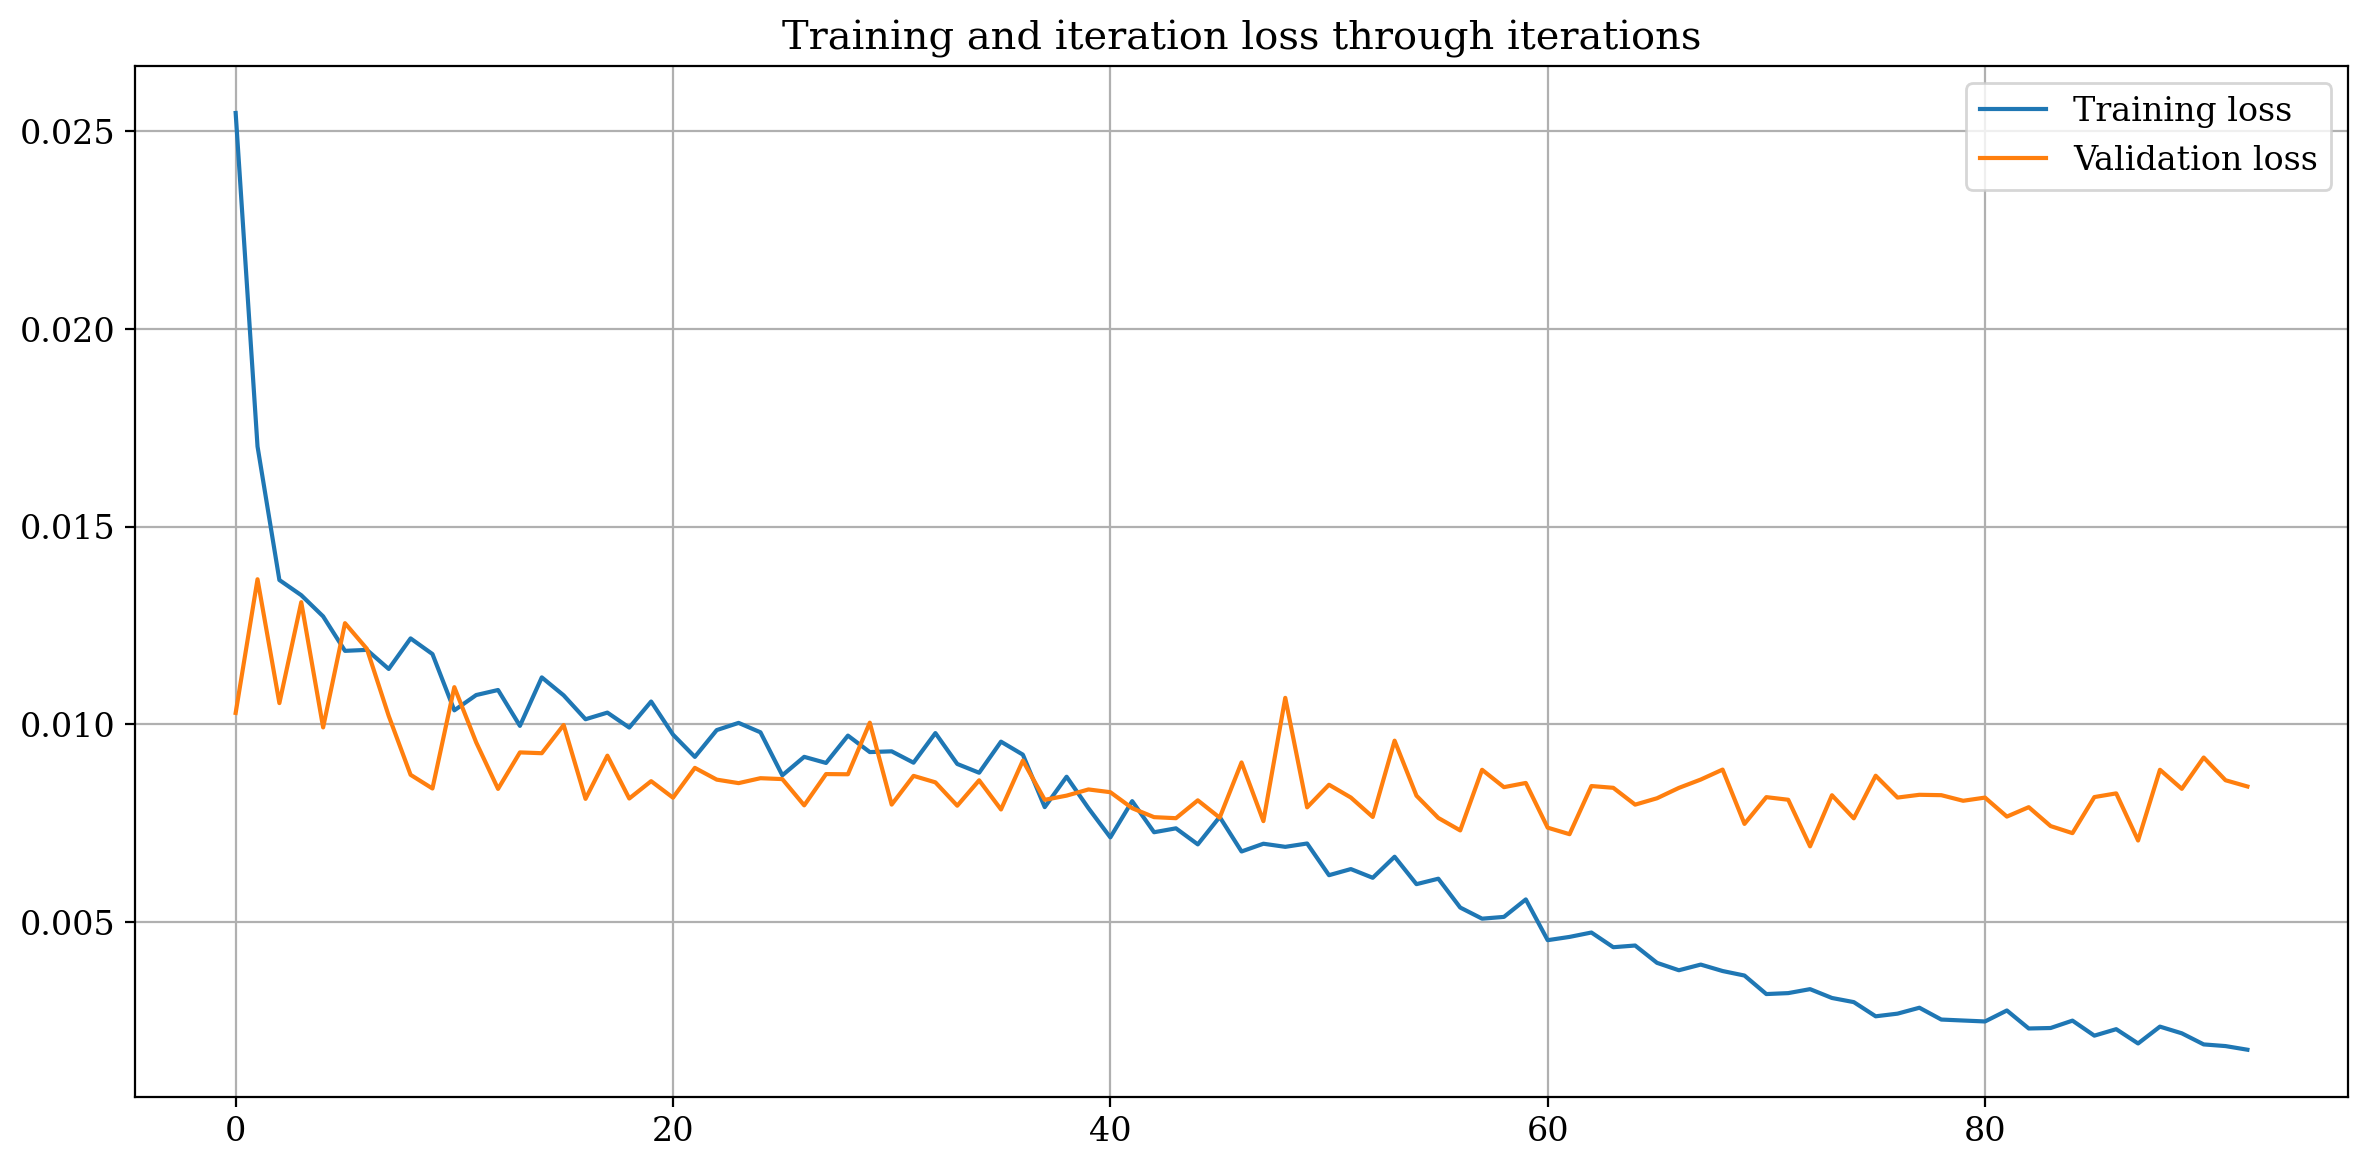

In [ ]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and iteration loss through iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
min_val_loss = min(history.history['val_loss'])
min_val_loss_epoch = np.argmin(history.history['val_loss'])+1
print(f"Minimum validation loss of {min_val_loss} reached at epoch {min_val_loss_epoch}")

Minimum validation loss of 0.006914197467267513 reached at epoch 73


In [13]:
model = load_model('checkpoints_Transformer_daily\model_epoch_73.h5')

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

2/2 [==============================] - 5s 2s/step
Score (RMSE): 0.07783183258817311


In [14]:
pred = scaler.inverse_transform(pred)

data = [(float(element), i+1) for i, element in enumerate(pred)]
query = "UPDATE rq3_test_predictions_daily SET transformer_nn = %s WHERE id = %s"
cursor.executemany(query, data)
db_connection.commit()

In [16]:
query = '''
SELECT
    DATE_FORMAT(u.date_time, '%Y-%m-%d %H:00:00') as hour, 
    COUNT(*) as count,
    MAX(t.boxing_day) as boxing_day,
    MAX(t.boxing_day_obs) as boxing_day_obs,
    MAX(t.christmas_day) as christmas_day,
    MAX(t.christmas_day_obs) as christmas_day_obs,
    MAX(t.good_friday) as good_friday,
    MAX(t.may_day) as may_day,
    MAX(t.new_years_day) as new_years_day,
    MAX(t.new_years_day_obs) as new_years_day_obs,
    MAX(t.platinum_jubilee) as platinum_jubilee,
    MAX(t.spring_bank_holiday) as spring_bank_holiday,
    MAX(t.state_funeral) as state_funeral,
    MAX(t.outlier) as outlier
FROM use_of_force u
LEFT JOIN rq3_add_variables t 
  ON DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00') = t.date
WHERE u.date_time > '2019-01-01 00:00:00' AND u.PrimaryConduct > 0
GROUP BY DATE_FORMAT(u.date_time, '%Y-%m-%d %H:00:00');
'''
time_series_hourly = pd.read_sql(query, db_connection)

time_series_hourly['hour'] = pd.to_datetime(time_series_hourly['hour'])
time_series_hourly.set_index('hour', inplace=True)
time_series_hourly = time_series_hourly.resample('H').sum()
time_series_hourly = time_series_hourly.reset_index()

scaler = MinMaxScaler()
time_series_hourly['count'] = scaler.fit_transform(time_series_hourly[['count']])

time_series_hourly['hour'] = pd.to_datetime(time_series_hourly['hour'])
time_series_hourly = time_series_hourly.set_index('hour')  
df = time_series_hourly[['count', 'boxing_day', 'boxing_day_obs', 'christmas_day',
       'christmas_day_obs', 'good_friday', 'may_day', 'new_years_day',
       'new_years_day_obs', 'platinum_jubilee', 'spring_bank_holiday',
       'state_funeral', 'outlier']].values

C:\Users\Nikita\AppData\Local\Temp/ipykernel_17400/2800974586.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_hourly = pd.read_sql(query, db_connection)


In [17]:
sequence_size = 30*24
x, y = to_sequences(sequence_size, df)

train_test_split_index = len(x) - 24*7
x_train = x[:train_test_split_index]
y_train = y[:train_test_split_index]
x_test = x[train_test_split_index:]
y_test = y[train_test_split_index:]
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (27574, 720, 13)
Shape of test set: (168, 720, 13)


In [ ]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[128, 64],
    mlp_dropout=0.2,
    dropout=0.2,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

os.makedirs("checkpoints_Transformer_agg_multi_hourly", exist_ok=True)
model_checkpoint = ModelCheckpoint('checkpoints_Transformer_agg_multi_hourly/model_epoch_{epoch:02d}.h5', 
                                   monitor='val_loss', verbose=1, save_best_only=False, mode='min')

early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, monitor='val_loss')

history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    shuffle=False,
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint],
)
model.evaluate(x_test, y_test, verbose=1)

Epoch 1/100
3102/3102 [==============================] - ETA: 0s - loss: 0.0069
Epoch 1: saving model to checkpoints_Transformer_agg_multi_hourly\model_epoch_01.h5
3102/3102 [==============================] - 218s 69ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 2/100
3102/3102 [==============================] - ETA: 0s - loss: 0.0052
Epoch 2: saving model to checkpoints_Transformer_agg_multi_hourly\model_epoch_02.h5
3102/3102 [==============================] - 215s 69ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 3/100
3102/3102 [==============================] - ETA: 0s - loss: 0.0049
Epoch 3: saving model to checkpoints_Transformer_agg_multi_hourly\model_epoch_03.h5
3102/3102 [==============================] - 215s 69ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 4/100
3102/3102 [==============================] - ETA: 0s - loss: 0.0047
Epoch 4: saving model to checkpoints_Transformer_agg_multi_hourly\model_epoch_04.h5
3102/3102 [==============================] - 215s 69ms/step - 

0.003237871453166008

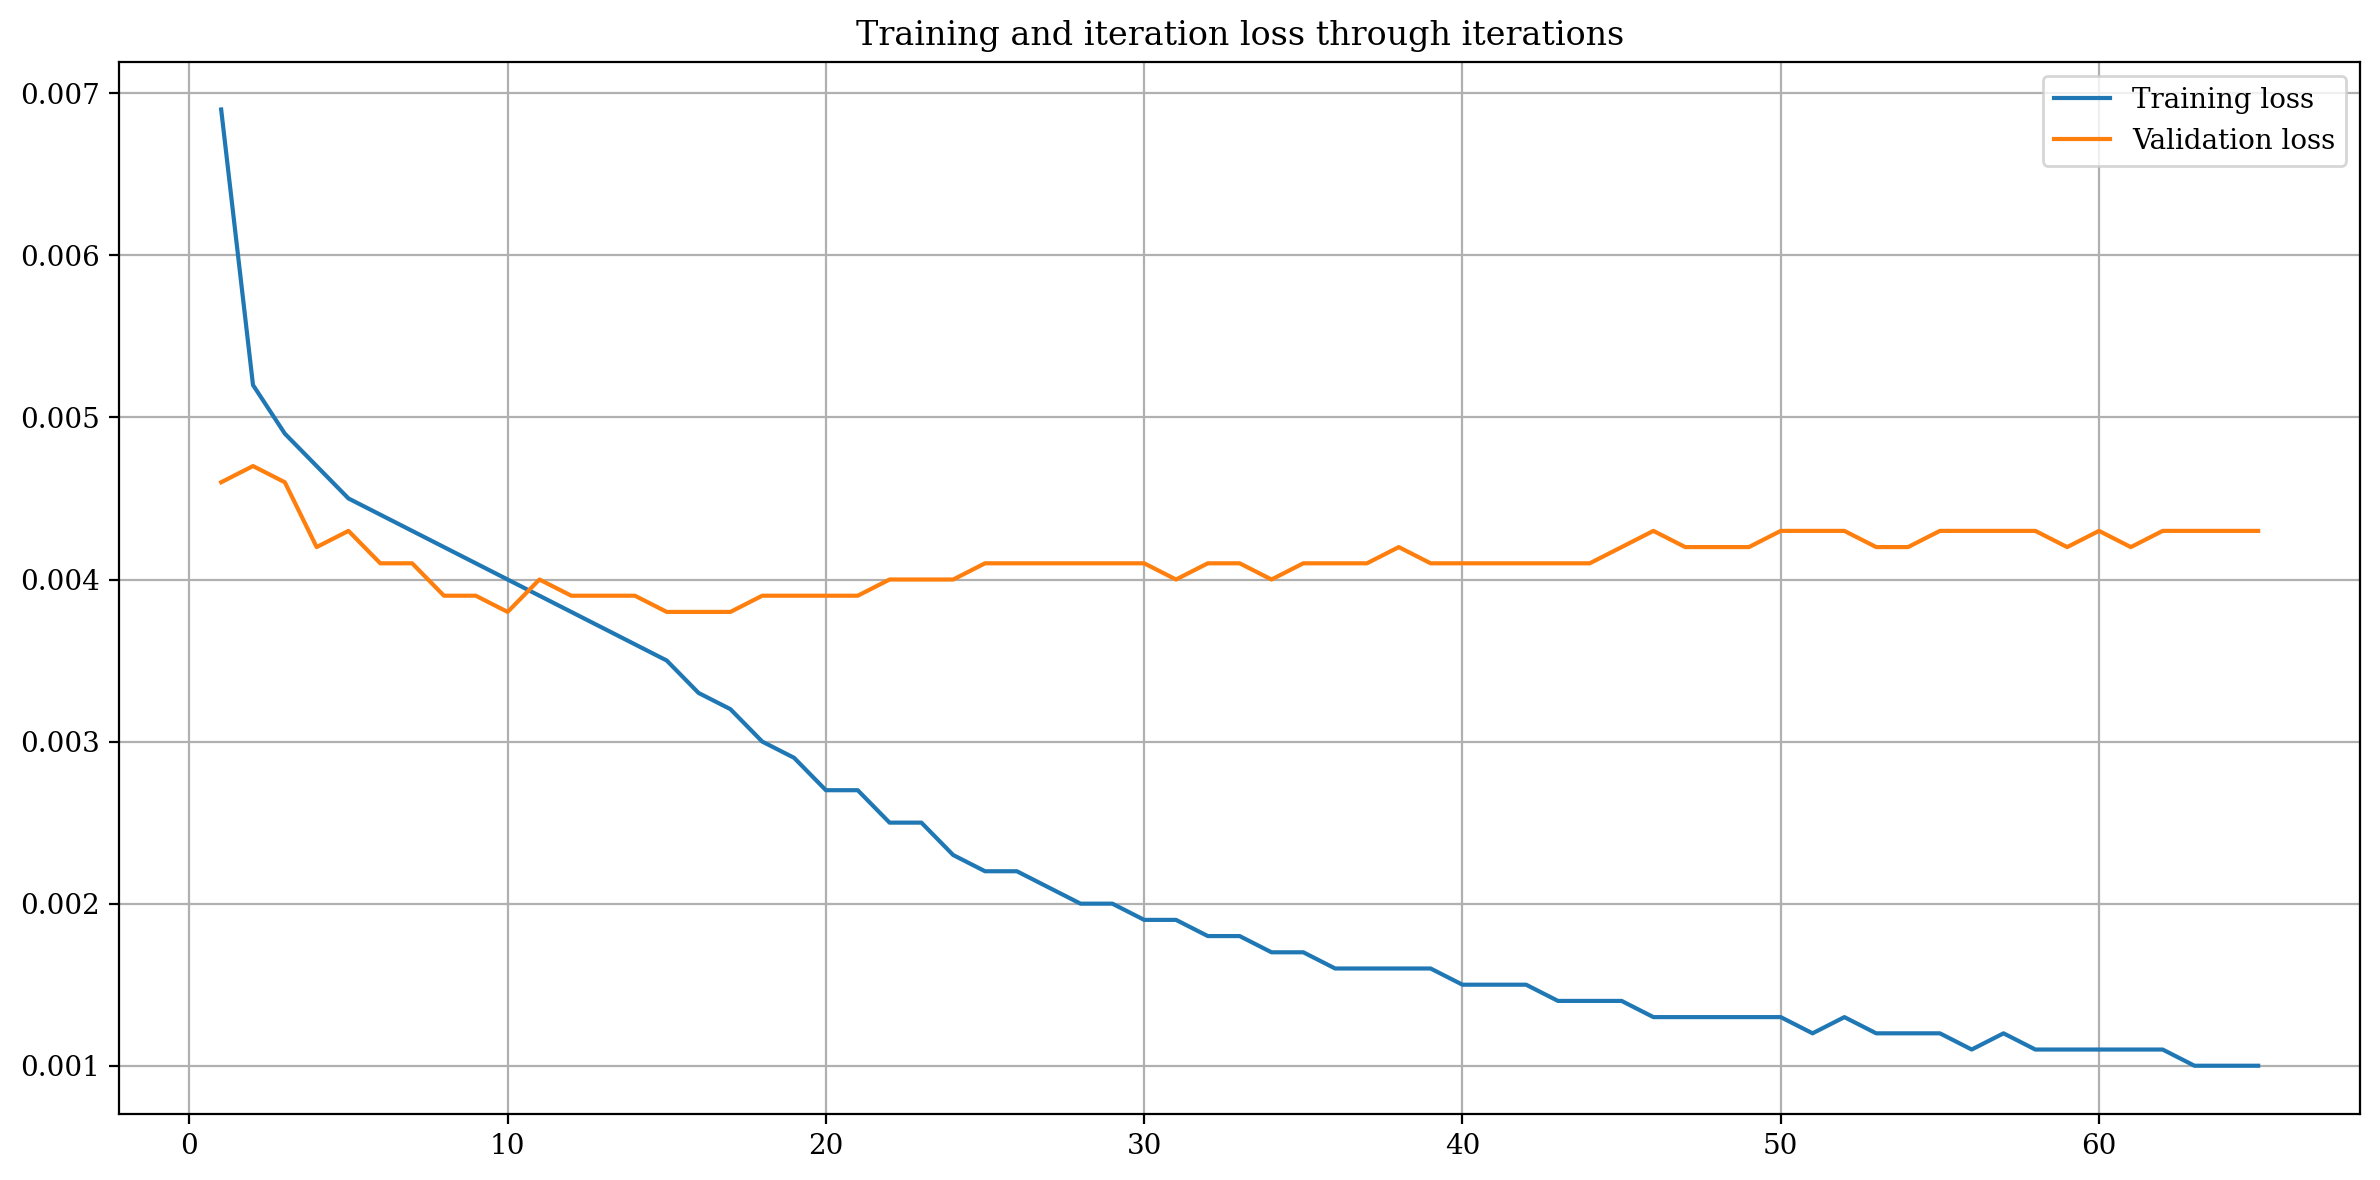

In [22]:
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and iteration loss through iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
min_val_loss = min(history.history['val_loss'])
min_val_loss_epoch = np.argmin(history.history['val_loss'])+1
print(f"Minimum validation loss of {min_val_loss} reached at epoch {min_val_loss_epoch}")

Minimum validation loss of 0.0038130420725792646 reached at epoch 15


In [19]:
model = load_model('checkpoints_Transformer_hourly\model_epoch_50.h5')

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

6/6 [==============================] - 16s 3s/step
Score (RMSE): 0.06133771146656638


In [20]:
pred = scaler.inverse_transform(pred)

data = [(float(element), i+1) for i, element in enumerate(pred)]
query = "UPDATE rq3_test_predictions_hourly SET transformer_nn = %s WHERE id = %s"
cursor.executemany(query, data)
db_connection.commit()